In [1]:
print("Preparing environment...")

import platform

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from astropy import table as tbl
from astropy import units as u
from astropy.io import fits
from astropy import constants as c
from scipy import interpolate
from tqdm.auto import tqdm
from itertools import chain

# %matplotlib widget
plt.rcParams["savefig.facecolor"] = "w"

print("Done.")

Preparing environment...
Done.


In [5]:
((1 * u.Jy) * c.c / (1.9 * u.m)**2).to(u.erg / u.cm**2 / u.s / u.angstrom)

<Quantity 8.30450022e-26 erg / (Angstrom cm2 s)>

In [ ]:
u.angstrom

In [124]:
((1 * u.Jy).si * c.c).to(u.erg / u.s / u.angstrom)

<Quantity 2.99792458e-21 erg / (Angstrom s)>

In [ ]:
u.Jy.cgs

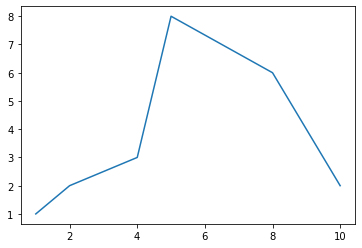

41.0
41.0
1.3


0.447213595499958

In [195]:
testGrid = np.array([1., 2., 4., 5., 8., 10.])
testVals = np.array([1., 2., 3., 8., 6., 2.])
testErrs = np.array([0.1, 0.2, 0.2, 0.1, 0.1, 0.2])
plt.close("all")
plt.plot(testGrid, testVals)
plt.show()
print(np.trapz(testVals, x=testGrid))
print(np.sum((testVals + np.roll(testVals, 1))[1:]/2 * (testGrid - np.roll(testGrid, 1))[1:]))
print(np.sum((testErrs + np.roll(testErrs, 1))[1:]/2 * (testGrid - np.roll(testGrid, 1))[1:]))
np.sqrt(np.sum((np.sqrt(testErrs**2 + np.roll(testErrs**2, 1))[1:]/2 * (testGrid - np.roll(testGrid, 1))[1:])**2))

In [216]:
### All functions


# Function to parse tables and set any rows with NaNs to zero, to avoid errors
def RemoveNaNs(tableObj):
    for col in tableObj.colnames:
        for x in range(0, len(tableObj[col]), 1):
            if np.isnan(tableObj[col][x]):
                tableObj[col][x] = 0
    return tableObj


# Function to use appropriate OS directory structure
def GetDirStruct():
    match platform.system():
        case "Windows":
            dirPrefix = "D:/"
        case "Linux" | "Ubuntu":
            dirPrefix = "/mnt/d/"
        case "macOS" | "Darwin":
            dirPrefix = "/Volumes/Storage/"
        case _:
            raise Exception(
                f'OS not recognised: "{platform.system()}". Please define a custom switch inside GetDirStruct().'
            )
    return dirPrefix


# Function to grab list of spectra in a directory
def GetSpec():
    dirPrefix = GetDirStruct()
    specDir = dirPrefix + specFolder
    specList = !bash -c "ls {specDir}*1D.fits"
    specList = [file.split("/")[-1] for file in specList]
    specNames = [file.split("_")[0] for file in specList]
    return specDir, specList, specNames


# Function to import files to dictionary
def ImportSpec(specDir, specList, specNames):
    specData = {}
    for file, name in tqdm(list(zip(specList, specNames)), desc="Importing spectra"):
        specRaw = fits.open(specDir + file)
        specFlux = specRaw[1].data * (u.erg / u.cm**2 / u.s / u.m)
        specErr = specRaw[2].data * (u.erg / u.cm**2 / u.s / u.m)
        specWave = specRaw[9].data * u.m
        specData[name] = tbl.QTable(
            [specWave, specFlux, specErr], names=("Wavelength", "Flux", "Error")
        )
        specData[name] = RemoveNaNs(specData[name])
        specRaw.close()
    return specData


# Function to plot the spectra
def PlotSpec(specData, specList, specNames):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/spectra/"
    for file, name in tqdm(
        zip(specList, specNames), desc="Plotting spectra", total=len(specList)
    ):
        plt.plot(specData[name]["Wavelength"], specData[name]["Flux"])
        plt.xscale("log")
        plt.savefig(
            f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}plots/spectra/{name}.png"
        )
        plt.close()
    return


# Function to grab list of filter curves
def GetFilter():
    dirPrefix = GetDirStruct()
    filterDir = dirPrefix + filterFolder
    filterList = !bash -c "ls {filterDir}"
    filterList = [file.split("/")[-1] for file in filterList]
    filterNames = [file.split("_")[0] for file in filterList]
    return filterDir, filterList, filterNames


# Function to import filters to a dictionary
def ImportFilter(filterDir, filterList, filterNames):
    filterData = {}
    for file, name in tqdm(
        zip(filterList, filterNames), desc="Importing filters", total=len(filterList)
    ):
        filterData[name] = tbl.QTable.read(filterDir + file, format="ascii")
        filterData[name]["Microns"].unit = u.um
        filterData[name].rename_column("Microns", "Wavelength")
        filterData[name]["Throughput"].unit = u.dimensionless_unscaled
        filterData[name] = RemoveNaNs(filterData[name])
    return filterData


# Function to interpolate datapoints
def InterpFunc(funcXs, funcYs):
    return interpolate.interp1d(funcXs, funcYs, kind="cubic")


# Function to find grid overlap for convolutions of target using input
def FindGrid(targetGrid, inputGrid, inputData):
    # Sort all arrays
    idxSorted = np.argsort(inputGrid)
    sortedGrid = inputGrid[idxSorted]
    sortedTarget = np.sort(targetGrid)
    # Find first value in input that overlaps with target
    if sortedGrid[0] < sortedTarget[0]:
        idxLeft = np.searchsorted(sortedGrid, sortedTarget[0], side="right")
        if inputGrid[idxLeft - 1] == sortedTarget[0]:
            idxLeft -= 1
    else:
        idxLeft = 0
    # Find last value in input that overlaps with target
    if sortedGrid[-1] > sortedTarget[-1]:
        idxRight = np.searchsorted(sortedGrid, sortedTarget[-1], side="left")
        if inputGrid[idxRight] != sortedTarget[-1]:
            idxRight -= 1
    else:
        idxRight = -1
    # Return the section of input that overlaps target
    overlapGrid = sortedGrid[idxLeft:idxRight]
    overlapData = inputData[idxSorted][idxLeft:idxRight]
    return overlapGrid, overlapData


# Function to manage convolution calculation from first array onto second array
def ConvolveFunc(firstXs, firstYs, secondXs, secondYs):
    # Interpolate datapoints of first array
    firstInterp = InterpFunc(firstXs.to(u.m), firstYs)
    # Find portion of relevant convolution grid for first array based on second array
    secondOverlapGrid, secondOverlapData = FindGrid(firstXs, secondXs, secondYs)
    # Convolve first array onto second array's grid
    firstConvolved = firstInterp(secondOverlapGrid.to(u.m)) * firstYs.unit
    return firstConvolved, secondOverlapGrid, secondOverlapData


# Function to convolve spectra and filters onto same grid
def MergeGrids(specFile, filterFile):
    # Find mutual overlaps
    specConvolved, filterOverlapGrid, filterOverlapData = ConvolveFunc(
        specFile["Wavelength"],
        specFile["Flux"],
        filterFile["Wavelength"],
        filterFile["Throughput"],
    )
    filterConvolved, specOverlapGrid, specOverlapData = ConvolveFunc(
        filterFile["Wavelength"],
        filterFile["Throughput"],
        specFile["Wavelength"],
        specFile["Flux"],
    )
    # Save as tables
    specTable = tbl.QTable(
        [
            np.append(specOverlapGrid, filterOverlapGrid).to(u.m),
            np.append(specOverlapData, specConvolved),
        ],
        names=("Wavelength", "Flux"),
    )
    specTable.sort("Wavelength")
    filterTable = tbl.QTable(
        [
            np.append(filterOverlapGrid, specOverlapGrid).to(u.m),
            np.append(filterOverlapData, filterConvolved),
        ],
        names=("Wavelength", "Throughput"),
    )
    filterTable.sort("Wavelength")
    # Join tables
    mergedTable = tbl.join(specTable, filterTable, keys="Wavelength")
    # Include error table only for spectral grid (errors should not be interpolated onto filter grid)
    filterConvolvedErr, errOverlapGrid, errOverlapData = ConvolveFunc(
        filterFile["Wavelength"],
        filterFile["Throughput"],
        specFile["Wavelength"],
        specFile["Error"],
    )
    errorTable = tbl.QTable(
        [errOverlapGrid.to(u.m), errOverlapData, filterConvolvedErr],
        names=("Wavelength", "Error", "Throughput"),
    )
    return mergedTable, errorTable


# Function to shift flux to photon space
def ShiftPhotonSpace(tableFlux, tableWave):
    tableFlux *= tableWave
    return


# Function to calculate throughput on a merged grid
def CalcThroughput(firstYs, secondYs, commonGrid, errYs, errY2s, errGrid):
    combinedYs = firstYs * secondYs
    combinedErrs = errYs * errY2s
    # Trapezoidal rule: SUM( 1/2 * (f(a) + f(b)) * (b - a) )
    specThrough = np.sum(
        (combinedYs + np.roll(combinedYs, 1))[1:]
        / 2
        * (commonGrid - np.roll(commonGrid, 1))[1:]
    )
    # Error propagation: SQRT( SUM( ( 1/2 * SQRT( df(a)^2 + df(b)^2 ) * (b - a) )^2 ) )
    errThrough = np.sqrt(
        np.sum(
            (
                np.sqrt(combinedErrs**2 + np.roll(combinedErrs**2, 1))[1:]
                / 2
                * (errGrid - np.roll(errGrid, 1))[1:]
            )
            ** 2
        )
    )
    return specThrough, errThrough
    # return np.trapz(firstYs * secondYs, x=commonGrid) # * (firstYs.unit * secondYs.unit * commonGrid.unit)


# Function to find throughput given a spectrum and filter
def FindThroughput(specFile, filterFile):
    # Convolve onto the same grid
    mergedTable, errorTable = MergeGrids(specFile, filterFile)
    # Shift to photon space
    ShiftPhotonSpace(mergedTable["Flux"], mergedTable["Wavelength"])
    ShiftPhotonSpace(errorTable["Error"], errorTable["Wavelength"])
    # Integrate through the filter
    specThrough, errThrough = CalcThroughput(
        mergedTable["Flux"],
        mergedTable["Throughput"],
        mergedTable["Wavelength"],
        errorTable["Error"],
        errorTable["Throughput"],
        errorTable["Wavelength"],
    )
    # errThrough = np.sqrt(CalcThroughput(errorTable["Error"]**2, errorTable["Throughput"], errorTable["Wavelength"]))
    # errThrough = np.sqrt(np.average(errorTable["Error"]**2, weights=errorTable["Throughput"] * errorTable["Wavelength"]))
    return specThrough, mergedTable, errThrough, errorTable


# Function to grab central wavelength of filter
def FindCentral(filterWave, filterThrough):
    return np.average(
        filterWave, weights=filterThrough
    )  # Weighted by throughput, not all wavelengths contribute equally


# Function to normalise the throughput to the correct zero-point
def NormaliseValue(specTable, specValue, filterFile):
    specThrough = specTable["Throughput"]
    specGrid = specTable["Wavelength"]
    # norm_ref = 10**(48.6/(-2.5)) # reference zero magnitude
    normRef = 1 * u.Jy  # * 10**(-9) # reference flat-value in f_nu
    normYs = (normRef * c.c / specGrid**2).to(
        u.erg / u.cm**2 / u.s / u.angstrom
    ) * specGrid  # reference flat-value in photon space, units removed
    normValue = (
        IntegFunc(specThrough, normYs, specGrid).to(specValue.unit).value
    )  # magnitude of normalisation factor
    specNormed = (specValue / normValue).to(
        u.erg / u.s / u.cm
    )  # throughput in photon space
    specNormed = (specNormed / FindCentral(filterFile["Wavelength"], filterFile["Throughput"])).to(u.W / u.m**2) # throughput in wavelength space
    # print(specNormed.to(u.W / u.m**2))
    # specNormed = (specNormed / FindCentral(filterFile["Wavelength"], filterFile["Throughput"])).to(u.erg / u.s / u.cm**2) # throughput in wavelength space
    return specNormed


def BalmerBreak(specFile, specName, redshiftFile):
    # Define regions
    balmerLeftRange = np.array([3500, 3650]) * u.angstrom
    balmerRightRange = np.array([3800, 3950]) * u.angstrom
    # Grab relevant grids
    for row in range(0, len(redshiftFile), 1):
        if (
            int(specName) == int(redshiftFile[row][redshiftID])
            and redshiftFile[row][redshiftZ] > 0
        ):
            redshiftFactor = 1 + redshiftFile[row][redshiftZ]
            break
        else:
            redshiftFactor = np.nan
    if redshiftFactor != 0:
        balmerLeftWave, balmerLeftSpec = FindGrid(
            balmerLeftRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Flux"] * redshiftFactor,
        )
        _, balmerLeftErr = FindGrid(
            balmerLeftRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Error"] * redshiftFactor,
        )
        balmerLeftTable = tbl.QTable(
            [balmerLeftWave, balmerLeftSpec, balmerLeftErr],
            names=("Wavelength", "Flux", "Error"),
        )
        balmerRightWave, balmerRightSpec = FindGrid(
            balmerRightRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Flux"] * redshiftFactor,
        )
        _, balmerRightErr = FindGrid(
            balmerRightRange,
            specFile["Wavelength"] / redshiftFactor,
            specFile["Error"] * redshiftFactor,
        )
        balmerRightTable = tbl.QTable(
            [balmerRightWave, balmerRightSpec, balmerRightErr],
            names=("Wavelength", "Flux", "Error"),
        )
        # Shift to photon space
        ShiftPhotonSpace(balmerLeftTable["Flux"], balmerLeftTable["Wavelength"])
        ShiftPhotonSpace(balmerLeftTable["Error"], balmerLeftTable["Wavelength"])
        ShiftPhotonSpace(balmerRightTable["Flux"], balmerRightTable["Wavelength"])
        ShiftPhotonSpace(balmerRightTable["Error"], balmerRightTable["Wavelength"])
        # Calculate average flux
        balmerLeftVal = np.sum(balmerLeftTable["Flux"]) / len(balmerLeftTable["Flux"])
        balmerRightVal = np.sum(balmerRightTable["Flux"]) / len(
            balmerRightTable["Flux"]
        )
        # Calculate ratio
        balmerRatio = balmerRightVal / balmerLeftVal
        balmerVals = [balmerLeftVal, balmerRightVal, balmerRatio]
    return balmerVals


# Function to loop through filters and balmer breaks for one spectrum
def HandleSpectrum(specFile, specName, filterData, redshiftFile):
    specValues = []
    for filterFile in filterData.values():
        specValue, specTable, errValue, errTable = FindThroughput(specFile, filterFile)
        specValues += [
            NormaliseValue(specTable, specValue, filterFile),
            NormaliseValue(errTable, errValue, filterFile),
        ]
    specValues += BalmerBreak(specFile, specName, redshiftFile)
    return specValues


# Function to loop through each spectrum and save values to a table
def LoopSpectra(specData, filterData, redshiftFile):
    !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}"
    rows = []
    for specName, specFull in tqdm(
        zip(specData.keys(), specData.values()),
        desc="Calculating throughputs",
        total=len(specData.keys()),
    ):
        rows += [
            [int(specName)]
            + HandleSpectrum(specFull, specName, filterData, redshiftFile)
        ]
    names = (
        ["ID"]
        + list(
            chain.from_iterable(
                [
                    [key + " Through", key + " Through Error"]
                    for key in filterData.keys()
                ]
            )
        )
        + ["Balmer_left", "Balmer_right", "Balmer_ratio"]
    )
    outTable = tbl.Table(rows=rows, names=names)
    outTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}throughputs_wavespace.fits",
        overwrite=True,
    )
    return outTable


# Function to import photometry files
def ImportPhot():
    photList = !bash -c "ls {photDir}/* | grep -v \"summary.fits\" | grep -v \"parameters.fits\""
    photList = [file.split("/")[-1] for file in photList]
    photTables = {}
    for file in tqdm(photList, desc="Importing apodised fluxes"):
        pointingNum = int(file.split("_")[-1].split(".")[0])
        photBand = file.split("_")[0]
        photRaw = tbl.QTable.read(f"{photDir}/{file}")
        try:
            photTables[pointingNum]
        except KeyError:
            photTables[pointingNum] = tbl.QTable()
            photTables[pointingNum].add_column(photRaw["ID"], name="ID")
        finally:
            tempTable = tbl.QTable()
            tempTable.add_columns(
                [photRaw["ID"], photRaw["Actual Flux"], photRaw["Flux Error"]],
                names=["ID", f"{photBand} Flux", f"{photBand} Error"],
            )
            photTables[pointingNum] = tbl.join(
                photTables[pointingNum], tempTable, keys="ID", join_type="left"
            )
    return photTables


# Function to import Astrometry
def ImportAstro():
    astroTables = {}
    dirPrefix = GetDirStruct()
    for slit, point in tqdm(
        list(zip(slitNums, pointNums)), desc="Importing astrometry"
    ):
        sourceList = tbl.QTable.read(
            f"{dirPrefix}/Astrometry/{astroDir}/{pointFolder}/{pointPrefix}{point}{pointSuffix}",
            format="ascii",
        )
        sourceAstro = tbl.QTable.read(
            f"{dirPrefix}/Astrometry/{astroDir}/{slitFolder}/{slitPrefix}{slit}{slitSuffix}",
            format="ascii",
        )
        astroTables[point] = tbl.join(sourceList, sourceAstro, keys="ID")
        astroTables[point]["Source_RA"].unit = u.degree
        astroTables[point]["Source_Dec"].unit = u.degree
    return astroTables


# Function to grab list of slitloss corrections
def GrabSlitloss():
    lossDir = GetDirStruct() + lossFolder
    lossList = {}
    for lossPoint in tqdm(lossPoints, desc="Grabbing slitlosses"):
        lossList[lossPoint] = {}
        for lossExp in tqdm(lossExps, desc="Extracting IDs", leave=False):
            lossNames = !bash -c "ls {lossDir}/{lossPoint}/{lossPrefix01}{lossPoint}_{lossExp}{lossPrefix02}*{lossSuffix}"
            lossNames = [
                f"{file.split('/')[-2]}/{file.split('/')[-1]}" for file in lossNames
            ]
            lossIDs = [
                int(file.split("_")[-3].split("idcat")[-1]) for file in lossNames
            ]
            lossList[lossPoint][lossExp] = tbl.Table(
                [lossIDs, lossNames], names=("ID", "Name")
            )
    return lossDir, lossList


# Function to import slitloss corrections
def ImportSlitloss(lossDir, lossList, photTables):
    lossData = {}
    for pointNum, pointName in tqdm(
        list(zip(pointNums, lossPoints)), desc="Importing slitlosses"
    ):
        IDList = tbl.Table([photTables[pointNum]["ID"]])
        lossData[pointName] = {}
        for lossExp in tqdm(
            lossList[pointName].keys(), desc="Parsing exposures", leave=False
        ):
            lossData[pointName][lossExp] = {}
            lossData[pointName][lossExp]["Index"] = tbl.join(
                lossList[pointName][lossExp], IDList, keys="ID"
            )
            for row in tqdm(
                range(0, len(lossData[pointName][lossExp]["Index"]), 1),
                desc="Matching IDs",
                leave=False,
            ):
                galID = lossData[pointName][lossExp]["Index"][row]["ID"]
                galName = lossData[pointName][lossExp]["Index"][row]["Name"]
                lossData[pointName][lossExp][galID] = tbl.QTable.read(
                    lossDir + galName, format="ascii"
                )
                lossData[pointName][lossExp][galID].rename_column("col1", "Slitloss")
                lossData[pointName][lossExp][galID].rename_column("col2", "Wavelength")
                lossData[pointName][lossExp][galID][
                    "Slitloss"
                ].unit = u.dimensionless_unscaled
                lossData[pointName][lossExp][galID]["Wavelength"].unit = u.um
            del lossData[pointName][lossExp]["Index"]
    return lossData


# Function to calculate photometry ratios
def CalcSlitRatio(photTable, specTable, pointNum):
    combTable = tbl.join(photTable, specTable, keys="ID")
    firstFlux = 1
    firstThrough = len(photTable.colnames)
    fluxCols = combTable.colnames[firstFlux:firstThrough:2]
    fluxErrCols = combTable.colnames[firstFlux + 1 : firstThrough + 1 : 2]
    throughCols = combTable.colnames[firstThrough::2]
    ratioTable = tbl.QTable([combTable["ID"]])
    fluxNames = []
    for col in combTable.colnames[1:]:
        combTable[col] = np.where(combTable[col] > 0, combTable[col], np.nan)
    # # 5 sigma selection criteria
    # for fluxCol, errCol in list(zip(fluxCols, fluxErrCols)):
    #     combTable[fluxCol] = np.where(combTable[fluxCol] / combTable[errCol] >= 5.0, combTable[fluxCol], np.nan)
    # # 2 sigma selection criteria
    # for fluxCol, errCol in list(zip(fluxCols, fluxErrCols)):
    #     combTable[fluxCol] = np.where(combTable[fluxCol] / combTable[errCol] >= 5.0, combTable[fluxCol], np.nan)
    # # 20 nJy selection criteria
    # for fluxCol in fluxCols:
    #     combTable[fluxCol] = np.where(combTable[fluxCol] >= 20.0 * u.nJy, combTable[fluxCol], np.nan)
    # # 50 nJy selection criteria
    # for fluxCol in fluxCols:
    #     combTable[fluxCol] = np.where(combTable[fluxCol] >= 50.0 * u.nJy, combTable[fluxCol], np.nan)
    # 100 nJy selection criteria
    for fluxCol in fluxCols:
        combTable[fluxCol] = np.where(
            combTable[fluxCol] >= 100.0 * u.nJy, combTable[fluxCol], np.nan
        )
    for fluxCol in fluxCols:
        fluxName = fluxCol.split()[0]
        for throughCol in throughCols:
            throughName = throughCol.split()[0]
            if fluxName == throughName:
                ratioTable.add_columns(
                    [
                        combTable[fluxCol],
                        combTable[throughCol],
                        combTable[fluxCol] / combTable[throughCol],
                        np.nan,
                    ],
                    names=(
                        fluxCol,
                        throughCol,
                        f"{fluxName} Ratio",
                        f"{fluxName} Ratio Error",
                    ),
                )
                fluxNames += [fluxName]
    ratioTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}ratios_{pointNum}.fits",
        overwrite=True,
    )
    return ratioTable, fluxNames


# Function to calculate slit-losses at centre of filters
def CalcLossTable(lossData, fluxNames, lossTables, pointName):
    lossTables[pointName] = {}
    for exposure in lossData.keys():
        rows = []
        for galaxy in lossData[exposure].keys():
            row = []
            row += [galaxy]
            lossInterpolated = interpolate.interp1d(
                lossData[exposure][galaxy]["Wavelength"],
                lossData[exposure][galaxy]["Slitloss"],
            )
            for fluxName in fluxNames:
                centralWave = float(fluxName[1] + "." + fluxName[2:4]) * u.um
                centralLoss = lossInterpolated(centralWave)
                row += [1 / centralLoss * u.dimensionless_unscaled]
            rows += [row]
        names = ["ID"] + [f"{fluxName} slitloss" for fluxName in fluxNames]
        lossTables[pointName][exposure] = tbl.QTable(rows=rows, names=names)
    return lossTables


# Function to calculate slit-loss factor between photometry and model
def CalcDiffTable(ratioTable, lossTables, pointName):
    diffTable = tbl.QTable([ratioTable["ID"]])
    for exposure in lossTables.keys():
        matchedTable = tbl.join(ratioTable, lossTables[exposure], keys="ID")
        firstRatio = 3
        firstLoss = len(ratioTable.colnames)
        ratioNames = matchedTable.colnames[firstRatio:firstLoss:4]
        lossNames = matchedTable.colnames[firstLoss:]
        tempTable = tbl.QTable([matchedTable["ID"]])
        for ratioName in ratioNames:
            for lossName in lossNames:
                if ratioName.split()[0] == lossName.split()[0]:
                    tempTable.add_column(
                        matchedTable[ratioName] / matchedTable[lossName],
                        name=f"{ratioName.split()[0]}_{exposure}_Diff",
                    )
        diffTable = tbl.join(diffTable, tempTable, keys="ID", join_type="outer")
    diffTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}differences_{pointName}_detailed.fits",
        overwrite=True,
    )
    return diffTable


# Function to append average differences across pointings and exposures
def CalcAverageDiff(diffTable, astroTable, pointName):
    colNames = diffTable.colnames[1:]
    # k = len(colNames)
    for i, colName_i in enumerate(colNames):
        stepSize = 0
        jumpSize = 0
        # for j, colName_j in enumerate(colNames[i+1:]):
        #     if colName_i.split('_')[0:2] == colName_j.split('_')[0:2]:
        #         stepSize = j + 1
        #         break
        # for j, colName_j in enumerate(colNames[i+stepSize::stepSize]):
        #     if colName_i.split('_')[0] == colName_j.split('_')[0] and colName_i.split('_')[1] != colName_j.split('_')[1]:
        #         jumpSize = (j + 1) * stepSize
        #         break
        for j, colName_j in enumerate(colNames[i + 1 :]):
            if colName_i.split("_")[0] == colName_j.split("_")[0]:
                stepSize = j + 1
                jumpSize = len(colNames)  # added to adjust for commented lines
                break
        if 0 not in [stepSize, jumpSize]:
            k = 0
            break
    # while k < len(colNames):
    #     for i, colName_i in enumerate(colNames[k:k+stepSize:1]):
    #         tempCol = diffTable[colName_i].copy().filled(0)
    #         count = np.where(tempCol > 0, 1, 0)
    #         for j, colName_j in enumerate(colNames[k+i+stepSize:k+i+jumpSize:stepSize]):
    #             tempCol += diffTable[colName_j].filled(0)
    #             count += np.where(diffTable[colName_j].filled(0) > 0, 1, 0)
    #         count = np.where(count > 0, count, np.nan)
    #         diffTable.add_column(tempCol/count, name=f"{colName_i.split('_')[0]}_{colName_i.split('_')[1]}")
    #     k += jumpSize
    # for i, colName_i in enumerate(colNames[0:stepSize]):
    #     tempCol = diffTable[colName_i].copy().filled(0)
    #     count = np.where(tempCol > 0, 1, 0)
    #     for j, colName_j in enumerate(colNames[i+stepSize::stepSize]):
    #         tempCol += diffTable[colName_j].filled(0)
    #         count += np.where(diffTable[colName_j].filled(0) > 0, 1, 0)
    #     count = np.where(count > 0, count, np.nan)
    #     diffTable.add_column(tempCol/count, name=f"{colName_i.split('_')[0]}")
    tempTable = tbl.QTable([diffTable["ID"]])
    while k < len(colNames):
        for i, colName_i in enumerate(colNames[k : k + stepSize : 1]):
            tempCol = diffTable[colName_i].copy()
            count = np.where(tempCol > 0, 1, 0)
            for j, colName_j in enumerate(
                colNames[k + i + stepSize : k + i : stepSize]
            ):
                tempCol += diffTable[colName_j]
                count += np.where(diffTable[colName_j] > 0, 1, 0)
            count = np.where(count > 0, count, np.nan)
            tempTable.add_column(
                tempCol / count, name=f"{colName_i.split('_')[0]}_Diff"
            )
        k += jumpSize
    diffTable = tbl.join(tempTable, astroTable, keys="ID", join_type="left")
    diffTable.write(
        f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}differences_{pointName}.fits",
        overwrite=True,
    )
    return diffTable


# Function to handle slit-losses
def HandleSlitloss(lossData, photTables, astroTables, specTable):
    lossTables = {}
    diffTables = {}
    ratioTables = {}
    for pointNum, pointName in tqdm(
        list(zip(pointNums, lossPoints)), desc="Calculating difference factors"
    ):
        ratioTable, fluxNames = CalcSlitRatio(photTables[pointNum], specTable, pointNum)
        lossTables = CalcLossTable(
            lossData[pointName], fluxNames, lossTables, pointName
        )
        diffTable = CalcDiffTable(ratioTable, lossTables[pointName], pointName)
        diffTable = CalcAverageDiff(diffTable, astroTables[pointNum], pointName)
        ratioTables[pointNum] = ratioTable
        diffTables[pointNum] = diffTable
    return ratioTables, lossTables, diffTables


# Function to import difference factors
def ImportDiff():
    diffTables = {}
    # diffList = !bash -c "ls ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/differences*.fits | grep -v \"detailed.fits\""
    for pointName, pointNum in list(zip(lossPoints, pointNums)):
        for file in diffList:
            if file.split("/")[-1].split("_")[-1].split(".fits")[0] == pointName:
                diffTables[pointNum] = tbl.QTable.read(file)
    return diffTables


# Function to plot all difference factors by RA/Dec
def PlotDiffCoords(diffTables):
    print("Plotting coordinates...")
    for pointName, pointNum in tqdm(list(zip(lossPoints, pointNums)), desc="Pointings"):
        !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/"
        colIndices = np.arange(
            diffTables[pointNum].colnames.index("ID") + 1,
            diffTables[pointNum].colnames.index("Source_RA"),
        )
        colNames = diffTables[pointNum].colnames[colIndices[0] : colIndices[-1]]
        for plotCoord in tqdm(["RA", "Dec"], desc="Coordinates", leave=False):
            for plotLog in tqdm(["lin", "log"], desc="Plots", leave=False):
                for galaxy in tqdm(
                    range(0, len(diffTables[pointNum]["ID"]), 1),
                    desc="Galaxies",
                    leave=False,
                ):
                    plt.scatter(
                        [diffTables[pointNum][f"Source_{plotCoord}"][galaxy].value]
                        * len(colIndices[0:-1]),
                        np.array(list(diffTables[pointNum][colNames][galaxy])),
                        c=colIndices[0:-1],
                        cmap="jet_r",
                        s=2,
                    )
                cbar = plt.colorbar()
                cbar.set_ticklabels(
                    [colName.split("_")[0] for colName in colNames[0:-1]]
                )
                cbar.ax.set_title("Filter")
                plt.xlabel(f"{plotCoord} ({u.deg})")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotCoord == "RA":
                    plt.title("Difference Factors vs RA", wrap=True)
                elif plotCoord == "Dec":
                    plt.title("Difference Factors vs Dec", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/{plotCoord}_{plotLog}_byFilter_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
                for colName in tqdm(colNames, desc="Filters", leave=False):
                    plt.scatter(
                        [float(colName[1:4]) * 10] * len(diffTables[pointNum]),
                        diffTables[pointNum][colName],
                        c=diffTables[pointNum][f"Source_{plotCoord}"],
                        cmap="plasma",
                        s=2,
                    )
                cbar = plt.colorbar()
                cbar.ax.set_title(f"{plotCoord} ({u.degree})")
                plt.xlabel(f"Wavelength (nm)")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotCoord == "RA":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                elif plotCoord == "Dec":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/{plotCoord}_{plotLog}_byCoord_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
        for colName in tqdm(colNames, desc="Filters", leave=False):
            plt.scatter(
                diffTables[pointNum]["Source_RA"],
                diffTables[pointNum]["Source_Dec"],
                c=np.log10(diffTables[pointNum][colName]),
                cmap="tab20b",
                s=2,
            )
            cbar = plt.colorbar()
            cbar.ax.set_title("Log10(Difference factor)")
            plt.clim(np.log10(0.2), np.log10(5))
            plt.xlabel(f"RA ({u.deg})")
            plt.ylabel(f"Dec ({u.deg})")
            plt.title(f"{colName.split('_')[0]}")
            plt.title(f"RA vs Dec for {colName.split('_')[0]}", wrap=True)
            plt.savefig(
                f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/RA_Dec/Both_{colName.split('_')[0]}_{pointName}.png",
                dpi=300,
            )
            # plt.show()
            plt.close()
        # plt.show()
    return


# Function to plot all difference factors by offset
def PlotDiffOffsets(diffTables):
    print("Plotting offsets...")
    for pointName, pointNum in tqdm(list(zip(lossPoints, pointNums)), desc="Pointings"):
        !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/"
        colIndices = np.arange(
            diffTables[pointNum].colnames.index("ID") + 1,
            diffTables[pointNum].colnames.index("Source_RA"),
        )
        colNames = diffTables[pointNum].colnames[colIndices[0] : colIndices[-1]]
        for plotOffset in tqdm(["Offset_x", "Offset_y"], desc="Offsets", leave=False):
            for plotLog in tqdm(["lin", "log"], desc="Plots", leave=False):
                for galaxy in tqdm(
                    range(0, len(diffTables[pointNum]["ID"]), 1),
                    desc="Galaxies",
                    leave=False,
                ):
                    plt.scatter(
                        [diffTables[pointNum][f"{plotOffset}"][galaxy]]
                        * len(colIndices[0:-1]),
                        np.array(list(diffTables[pointNum][colNames][galaxy])),
                        c=colIndices[0:-1],
                        cmap="jet_r",
                        s=2,
                    )
                cbar = plt.colorbar()
                cbar.set_ticklabels(
                    [colName.split("_")[0] for colName in colNames[0:-1]]
                )
                cbar.ax.set_title("Filter")
                if plotOffset == "Offset_x":
                    plt.xlabel("Offset (x)")
                elif plotOffset == "Offset_y":
                    plt.xlabel("Offset (y)")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotOffset == "Offset_x":
                    plt.title("Difference Factors vs Offset (x)", wrap=True)
                elif plotOffset == "Offset_y":
                    plt.title("Difference Factors vs Offset (y)", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/{plotOffset}_{plotLog}_byFilter_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
                for colName in tqdm(colNames, desc="Filters", leave=False):
                    plt.scatter(
                        [float(colName[1:4]) * 10] * len(diffTables[pointNum]),
                        diffTables[pointNum][colName],
                        c=diffTables[pointNum][f"{plotOffset}"],
                        cmap="plasma",
                        s=2,
                    )
                cbar = plt.colorbar()
                if plotOffset == "Offset_x":
                    cbar.ax.set_title("Offset (x)")
                elif plotOffset == "Offset_y":
                    cbar.ax.set_title("Offset (y)")
                plt.xlabel(f"Wavelength (nm)")
                plt.axhline(1)
                plt.ylabel("Difference Factor")
                if plotLog == "lin":
                    plt.ylim(-1, 10)
                elif plotLog == "log":
                    plt.yscale("log")
                    plt.ylim(10 ** (-2), 10**2)
                if plotOffset == "Offset_x":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                elif plotOffset == "Offset_y":
                    plt.title("Difference Factors vs Wavelength", wrap=True)
                plt.savefig(
                    f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/{plotOffset}_{plotLog}_byOffset_{pointName}.png",
                    dpi=300,
                )
                # plt.show()
                plt.close()
        for colName in tqdm(colNames, desc="Filters", leave=False):
            plt.scatter(
                diffTables[pointNum]["Offset_x"],
                diffTables[pointNum]["Offset_y"],
                c=np.log10(diffTables[pointNum][colName]),
                cmap="tab20b",
                s=2,
            )
            cbar = plt.colorbar()
            cbar.ax.set_title("Log10(Difference factor)")
            plt.clim(np.log10(0.2), np.log10(5))
            plt.xlabel("Offset (x)")
            plt.ylabel("Offset (y)")
            plt.title(
                f"Offset (y) vs Offset (x) for {colName.split('_')[0]}", wrap=True
            )
            plt.savefig(
                f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/offsets/Both_{colName.split('_')[0]}_{pointName}.png",
                dpi=300,
            )
            # plt.show()
            plt.close()
        # plt.show()
    return


# Function for plotting galaxy wavelength dependence
def PlotDiffGals(diffTables):
    print("Plotting galaxies...")
    for pointName, pointNum in tqdm(list(zip(lossPoints, pointNums)), desc="Pointings"):
        !bash -c "mkdir -p ../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/galaxies/"
        colIndices = np.arange(
            diffTables[pointNum].colnames.index("ID") + 1,
            diffTables[pointNum].colnames.index("Source_RA"),
        )
        colNames = diffTables[pointNum].colnames[colIndices[0] : colIndices[-1]]
        for plotLog in tqdm(["lin", "log"], desc="Plots", leave=False):
            for galaxy in tqdm(
                range(0, len(diffTables[pointNum]["ID"]), 1),
                desc="Galaxies",
                leave=False,
            ):
                plt.scatter(
                    np.array([float(colName[1:4]) * 10 for colName in colNames]),
                    np.array(list(diffTables[pointNum][colNames][galaxy])),
                    s=2,
                )
            if plotLog == "lin":
                plt.ylim(0, 5)
            elif plotLog == "log":
                plt.yscale("log")
                plt.ylim(10 ** (-2), 10**2)
            plt.xlabel("Wavelength (nm)")
            plt.ylabel("Difference Factor")
            plt.axhline(1)
            plt.title(
                "Difference Factor vs Wavelength, color-coded by Galaxy", wrap=True
            )
            plt.savefig(
                f"../../Working_Directory/Apo_Phot_Utils/{outputFolder}/plots/galaxies/galaxies_{plotLog}_{pointName}.png",
                dpi=300,
            )
            # plt.show()
            plt.close()
    return

In [211]:
# Directories
try:
    filterFolder
    specFolder
    outputFolder
    photDir
    slitNums
    pointNums
    lossFolder
    lossPrefix
    lossSuffix
except NameError:
    print("Defining directories...")
    filterFolder = "Throughputs/nircam_throughputs/mean_throughputs/"
    specFolder = "Spectra/HST_Deep/prism_v1.5/"
    outputFolder = "HST_Deep/prism_v1.5/100nJy_sample/"
    photDir = "../../Working_Directory/Apo_Phot/HST_Deep/"
    astroDir = "HST_Deep/for_emma_v2a_clean2/prism_trial_01_v2a_clean2/"
    slitFolder = "m_make_output/"
    slitPrefix = "table"
    slitSuffix = ".txt"
    slitNums = [3, 2, 1]
    pointFolder = "m_check_output/triple_1/"
    pointPrefix = "pointing_"
    pointSuffix = "/ds9_targ_regions.txt"
    pointNums = [7, 8, 13]
    lossFolder = "Slit-losses/HST/pathlosses_deep_R100/R100_v0/"
    lossPoints = ["p01", "p02", "p03"]
    lossPrefix01 = "pathlosses_correction_deep_hst_1x1_"
    lossPrefix02 = "_idcat"
    lossExps = ["exp00", "exp01", "exp02"]
    lossSuffix = "_v0_point.txt"

# Filters
try:
    filterData
except NameError:
    filterDir, filterList, filterNames = GetFilter()
    filterData = ImportFilter(filterDir, filterList, filterNames)

# Redshift catalogue
try:
    redshiftFile
except NameError:
    redshiftFolder = GetDirStruct() + "Redshifts/Deep_HST.csv"
    redshiftID = "ID"
    redshiftZ = "Assigned_redshift"
    redshiftFile = tbl.Table.read(redshiftFolder)

Defining directories...


In [217]:
specTable = LoopSpectra(specData, filterData, redshiftFile)

Calculating throughputs:   0%|          | 0/253 [00:00<?, ?it/s]

In [218]:
specTable

ID,F070W Through,F070W Through Error,F090W Through,F090W Through Error,F115W Through,F115W Through Error,F140M Through,F140M Through Error,F150W2 Through,F150W2 Through Error,F150W Through,F150W Through Error,F162M Through,F162M Through Error,F164N Through,F164N Through Error,F182M Through,F182M Through Error,F187N Through,F187N Through Error,F200W Through,F200W Through Error,F210M Through,F210M Through Error,F212N Through,F212N Through Error,F250M Through,F250M Through Error,F277W Through,F277W Through Error,F300M Through,F300M Through Error,F322W2 Through,F322W2 Through Error,F323N Through,F323N Through Error,F335M Through,F335M Through Error,F356W Through,F356W Through Error,F360M Through,F360M Through Error,F405N Through,F405N Through Error,F410M Through,F410M Through Error,F430M Through,F430M Through Error,F444W Through,F444W Through Error,F460M Through,F460M Through Error,F466N Through,F466N Through Error,F470N Through,F470N Through Error,F480M Through,F480M Through Error,WLP4 Through,WLP4 Through Error,Balmer_left,Balmer_right,Balmer_ratio
,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,W / m2,erg / (cm2 s),erg / (cm2 s),
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2332,7.95843124867465e-09,8.077525760993007e-10,8.141005276196434e-09,5.902575831699759e-10,8.010977818070506e-09,4.0925119244561173e-10,7.86036989559788e-09,5.025200034691489e-10,8.175982455596749e-09,1.5213010458539712e-10,8.469264083257263e-09,3.455021148757933e-10,8.88458781909993e-09,4.795100476602192e-10,6.4510809491053276e-09,1.312157320787765e-09,1.1036946972184976e-08,3.595203856741707e-10,1.0691551968210526e-08,1.0291784429961198e-09,9.208506818456428e-09,2.406091082984101e-10,7.62993261604602e-09,3.3036648093230054e-10,6.450964155996391e-09,8.107014547514975e-10,8.198365932138696e-09,3.0158060337968906e-10,6.2006811996719705e-09,1.438716170445134e-10,5.1478652365262205e-09,1.9847453571087238e-10,5.3273444818391216e-09,9.551202871756397e-11,5.360797831932828e-09,5.699166540757792e-10,5.4105303305989085e-09,1.8878432688854087e-10,4.936207399558615e-09,1.2994172672117364e-10,4.62487451889125e-09,1.8715245426257533e-10,4.078924697649189e-09,6.360918785853577e-10,5.431390241815882e-09,2.0674022764408285e-10,5.4285472551539976e-09,3.13532657495076e-10,4.153654349771594e-09,1.5994948334802298e-10,2.6134890621632223e-09,3.7601851188653013e-10,1.9488030780492693e-09,7.837001190343595e-10,2.1946905495663933e-09,7.872879855289846e-10,3.1595023409739797e-09,3.4770108253428655e-10,7.521976224685306e-09,6.647240361518067e-10,nan,nan,nan
2375,3.466270968955652e-08,1.5142344490702366e-09,2.897257741242897e-08,1.0631471368835158e-09,3.816299407137343e-08,7.57120370882353e-10,3.874911071790426e-08,9.542472188402608e-10,3.356525377712361e-08,3.0148410164125764e-10,3.7917572648142e-08,6.577165412837878e-10,3.699989845707161e-08,9.089166860364507e-10,3.629080058924837e-08,2.450453022949738e-09,3.41007026313084e-08,7.275879786926657e-10,4.043669752566308e-08,2.219591472821342e-09,3.4446168908513216e-08,5.167209900144481e-10,3.293093957780118e-08,7.43414491731341e-10,2.9423158439135055e-08,1.7485873194850748e-09,2.674587281078938e-08,6.768209614732949e-10

In [112]:
# Spectra
try:
    specData
    specTable
except NameError:
    specDir, specList, specNames = GetSpec()
    specData = ImportSpec(specDir, specList, specNames)
    specTable = LoopSpectra(specData, filterData, redshiftFile)

Importing spectra:   0%|          | 0/253 [00:00<?, ?it/s]

Calculating throughputs:   0%|          | 0/253 [00:00<?, ?it/s]

5.621543928355422e-10 erg / (cm s)
7.95843124867465e-06 erg / (cm2 s)
7.363206061575232e-10 erg / (cm s)
8.141005276196433e-06 erg / (cm2 s)
9.26743885345249e-10 erg / (cm s)
8.010977818070506e-06 erg / (cm2 s)
1.1052085074501977e-09 erg / (cm s)
7.86036989559788e-06 erg / (cm2 s)
1.4050104213730353e-09 erg / (cm s)
8.175982455596749e-06 erg / (cm2 s)
1.2739041692588982e-09 erg / (cm s)
8.469264083257262e-06 erg / (cm2 s)
1.4464395885300186e-09 erg / (cm s)
8.88458781909993e-06 erg / (cm2 s)
1.0608988926792175e-09 erg / (cm s)
6.451080949105327e-06 erg / (cm2 s)
2.038113883693609e-09 erg / (cm s)
1.1036946972184976e-05 erg / (cm2 s)
2.0036742261475817e-09 erg / (cm s)
1.0691551968210526e-05 erg / (cm2 s)
1.834606878018765e-09 erg / (cm s)
9.208506818456429e-06 erg / (cm2 s)
1.5996242529978182e-09 erg / (cm s)
7.62993261604602e-06 erg / (cm2 s)
1.3684213964671227e-09 erg / (cm s)
6.450964155996392e-06 erg / (cm2 s)
2.0526228640385247e-09 erg / (cm s)
8.198365932138696e-06 erg / (cm2 s)


TypeError: ShiftPhotonSpace() missing 1 required positional argument: 'tableWave'

In [ ]:
# Photometry
try:
    photTables
except NameError:
    photTables = ImportPhot()
    
# Astrometry
try:
    astroTables
except NameError:
    astroTables = ImportAstro()

# Slitlosses
try:
    lossData
except NameError:
    lossDir, lossList = GrabSlitloss()
    lossData = ImportSlitloss(lossDir, lossList, photTables)

# Plots
# PlotSpec(specData, specList, specNames)

# Slit-losses
ratioTables, lossTables, diffTables = HandleSlitloss(lossData, photTables, astroTables, specTable)

print("\nDone.")

In [ ]:
print("Importing table...")
diffTables = ImportDiff()
PlotDiffCoords(diffTables)
PlotDiffOffsets(diffTables)
PlotDiffGals(diffTables)
print("Done.")

In [ ]:
plt.close("all")

# plt.plot(Spectrum["Wavelength"], Spectrum["Flux"])
# plt.plot(Filter["Wavelength"], Filter["Throughput"] * 10 **(-13))
plt.plot(Filter_grid, Filter_conv * 10 ** (-13), color="green")
plt.plot(Filter_grid, Spectrum_flux, color="blue")
plt.plot(Filter_grid, Filter_conv * Spectrum_flux, color="red")